# Jugando contra Hikaru Nakamura

<p style="float: right; margin-left: 15px;">
  <img src="Nakamura_foto.jpg" width="230">
</p>

Hikaru Nakamura es un Gran Maestro Internacional de ajedrez nacido en Japón y nacionalizado estadounidense. Reconocido por su estilo de juego agresivo y su rapidez mental, ha sido cinco veces campeón de Estados Unidos y es uno de los mejores jugadores de ajedrez blitz del mundo. Además de su exitosa carrera competitiva, Nakamura es una figura influyente en el mundo digital, conocido por sus transmisiones en vivo y su presencia en plataformas como Twitch y YouTube, donde ha contribuido significativamente a la popularización del ajedrez en línea.

Además, como veremos a lo largo de este *notebook*, Nakamura se ha mostrado muy activo en los dos últimos años y medio (un millón de partidas aprox.) siendo el jugador con más partidas de nuestra base de datos (2969 partidas -> 1492 partidas con blancas y 1477 con negras). 

A través de un modelo (red neuronal convolucional) entrenado con las partidas de este jugador generaremos un `jugador artificial` (bot) que responderá a nuestras jugadas al estilo Nakamura. Para ello, usando el motor Stockfish se generarán n=10 posibles movimientos que serán evaluados por nuestro modelo para tomar aquel que más se aproxime a la forma de jugar de este Gran Maestro. Todo ello siempre y cuando estos posibles valores superen un umbral preestrablecido. Si las jugadas en cuestión no se parecen en nada con las que ha entrenado nuestro modelo este devolverá muy probablemente un valor inferior al umbral y en este caso se elegirá la jugada que decida Stockfish (restringida al ELO del jugador).

## 1. Carga de librerías necesarias

In [1]:
# --- Librerías estándar de Python ---
import os
import io
import re
import numpy as np

# --- Librerías relacionadas con ajedrez ---
import chess
import chess.svg
import chess.pgn

# --- Visualización en Jupyter ---
from IPython.display import display, SVG

# --- PySpark: configuración y utilidades ---
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, explode, input_file_name, lit, count
from pyspark.sql.types import StringType, ArrayType, FloatType, StructType, StructField
from pyspark.ml.feature import StringIndexer


## 2. Visualización de la carpeta HDFS con el origen de datos (descargados con Airflow)

In [2]:
# Carpeta en HDFS con el origen de datos
!hdfs dfs -ls /user/ajedrez/raw

Found 124 items
-rw-r--r--   2 root supergroup    9538502 2025-05-18 18:28 /user/ajedrez/raw/twic1469.pgn
-rw-r--r--   2 root supergroup    6166218 2025-05-18 18:28 /user/ajedrez/raw/twic1470.pgn
-rw-r--r--   2 root supergroup    4904069 2025-05-18 18:28 /user/ajedrez/raw/twic1471.pgn
-rw-r--r--   2 root supergroup    4605869 2025-05-18 18:28 /user/ajedrez/raw/twic1472.pgn
-rw-r--r--   2 root supergroup    4617452 2025-05-18 18:28 /user/ajedrez/raw/twic1473.pgn
-rw-r--r--   2 root supergroup    8575952 2025-05-18 18:28 /user/ajedrez/raw/twic1474.pgn
-rw-r--r--   2 root supergroup    7371732 2025-05-18 18:28 /user/ajedrez/raw/twic1475.pgn
-rw-r--r--   2 root supergroup    5094270 2025-05-18 18:28 /user/ajedrez/raw/twic1476.pgn
-rw-r--r--   2 root supergroup    6262253 2025-05-18 18:28 /user/ajedrez/raw/twic1477.pgn
-rw-r--r--   2 root supergroup    5352534 2025-05-18 18:28 /user/ajedrez/raw/twic1478.pgn
-rw-r--r--   2 root supergroup    7013858 2025-05-18 18:28 /user/ajedrez/raw/twic147

## 3. Inicialización de la sesión de Spark
Creamos una sesión de *Spark* llamada spark. En `.master( )`

- `"yarn"` ejecuta la aplicación en un clúster distribuido gestionado por YARN. Esto permite paralelizar el procesamiento a gran escala, distribuyendo las tareas entre varios nodos del clúster.

- `"local[*]"` ejecuta Spark en modo local, usando todos los núcleos disponibles (*) en el equipo donde corre el script (en este ejemplo en el contenedor *spark-client*). Lo hemos usado para pruebas, el desarrollo del proyecto con datasets pequeños.

In [3]:
spark = (
    SparkSession.builder
    .appName("Bot_Nakamura")
    .master("yarn")  
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/13 11:12:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/13 11:12:08 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


## 4. Creación del dataframe de todas las partidas

Leemos los archivos PGN desde HDFS y los dividimos en partidas individuales. Extraemos algunos metadatos clave (jugadores, fecha, variante) y filtramos las partidas estándar (excluyendo Chess960 que es una variante donde las fichas se desordenan antes de empezar la partida).

El DataFrame resultante `df` contiene las siguientes columnas:

- `archivo`: ruta del archivo de origen donde se ha extraído la partida  
- `pgn`: texto completo de la partida en formato PGN  
- `white`: nombre del jugador con blancas  
- `black`: nombre del jugador con negras  
- `date`: fecha de la partida  
- `variant`: tipo de variante (nulo para partidas estándar)



In [4]:
# Leer archivos PGN de HDFS
rdd = spark.sparkContext.wholeTextFiles("hdfs:///user/ajedrez/raw/*.pgn")

# Función para dividir en partidas individuales
def dividir_partidas_por_archivo(nombre_y_contenido):
    ruta, contenido = nombre_y_contenido
    partidas = re.split(r'\n(?=\[Event )', contenido)
    return [(ruta, pgn) for pgn in partidas if "[Event" in pgn]

# Dividir partidas y convertir a DataFrame
rdd_partidas = rdd.flatMap(dividir_partidas_por_archivo)
df_raw = rdd_partidas.toDF(["archivo", "pgn"])

# Función para extraer tags
def extraer_tag(tag, texto):
    match = re.search(rf'\[{tag} "([^"]+)"\]', texto)
    return match.group(1) if match else None

# Registrar UDFs
extraer_white = udf(lambda x: extraer_tag("White", x), StringType())
extraer_black = udf(lambda x: extraer_tag("Black", x), StringType())
extraer_date = udf(lambda x: extraer_tag("Date", x), StringType())
extraer_variant = udf(lambda x: extraer_tag("Variant", x), StringType())

# Agregar columnas de metadatos
df_con_tags = df_raw.withColumn("white", extraer_white(col("pgn"))) \
                    .withColumn("black", extraer_black(col("pgn"))) \
                    .withColumn("date", extraer_date(col("pgn"))) \
                    .withColumn("variant", extraer_variant(col("pgn")))

# Filtrar solo partidas estándar (no Chess960)
df = df_con_tags.filter((col("variant").isNull()) | (col("variant") != "Chess960"))

In [5]:
# Características del Dataframe df (Todas las partidas clásicas)
# En PySpark los Dataframes no tienen atributo .shape
filas = df.count()
columnas = len(df.columns)
print(f"Filas y columnas del dataframe de todas las partidas: ({filas}, {columnas})")
print(df.columns)

[Stage 1:=============================>                             (1 + 1) / 2]

Filas y columnas del dataframe de todas las partidas: (1009722, 6)
['archivo', 'pgn', 'white', 'black', 'date', 'variant']


In [6]:
# Algunas partidas del Dataframe
df.select("archivo", "white", "black", "date").show(10,truncate=False)

+--------------------------------------------------+---------------------+----------------------+----------+
|archivo                                           |white                |black                 |date      |
+--------------------------------------------------+---------------------+----------------------+----------+
|hdfs://namenode:9000/user/ajedrez/raw/twic1469.pgn|Harutyunyan,Tigran K.|Brunello,S            |2022.12.26|
|hdfs://namenode:9000/user/ajedrez/raw/twic1469.pgn|Saraci,Nderim        |Vallejo Pons,F        |2022.12.26|
|hdfs://namenode:9000/user/ajedrez/raw/twic1469.pgn|Pranav,V             |Naiditsch,A           |2022.12.26|
|hdfs://namenode:9000/user/ajedrez/raw/twic1469.pgn|Arjun,Kalyan         |Adhiban,Baskaran      |2022.12.26|
|hdfs://namenode:9000/user/ajedrez/raw/twic1469.pgn|Daneshvar,Bardiya    |Ghasi,A               |2022.12.26|
|hdfs://namenode:9000/user/ajedrez/raw/twic1469.pgn|Idani,P              |Munkhgal,G            |2022.12.26|
|hdfs://namenode:90

In [7]:
# Primera partida del Dataframe de todas las partidas
print(df.select("pgn").first()["pgn"])

[Stage 5:>                                                          (0 + 1) / 1]

[Event "World Rapid 2022"]
[Site "Almaty KAZ"]
[Date "2022.12.26"]
[Round "5.58"]
[White "Harutyunyan,Tigran K."]
[Black "Brunello,S"]
[Result "0-1"]
[WhiteTitle "GM"]
[BlackTitle "GM"]
[WhiteElo "2511"]
[BlackElo "2519"]
[ECO "D35"]
[Opening "QGD"]
[Variation "exchange, positional line, 5...c6"]
[WhiteFideId "13303635"]
[BlackFideId "813613"]
[EventDate "2022.12.26"]

1. c4 Nf6 2. Nc3 e6 3. d4 d5 4. cxd5 exd5 5. Bg5 c6 6. e3 h6 7. Bh4 Be7 8. Bd3
O-O 9. Qc2 Re8 10. Nge2 a5 11. O-O Na6 12. a3 Nc7 13. Rad1 Ne6 14. f3 b5 15. Bf2
Bd7 16. Kh1 Qb8 17. e4 b4 18. Na4 dxe4 19. fxe4 bxa3 20. bxa3 Bxa3 21. Bg3 Qa7
22. Rxf6 gxf6 23. e5 Bf8 24. exf6 c5 25. d5 Nd4 26. Nxd4 cxd4 27. Qf2 Re3 28.
Nb2 Qb7 29. Nc4 Rxd3 30. Rg1 Qxd5 31. Nb6 Qc6 32. Nxa8 Qxa8 33. Bf4 Qe4 34. Re1 0-1



## 5. Buscamos los 10 jugadores con más partidas jugadas en ambos colores
Apreciamos una diferencia muy significativa en el tiempo de ejecución entre local ("local[*]") y en el cluster ("yarn").

In [8]:
# Contar partidas por jugador y color
df_blancas = df.select(col("white").alias("jugador")).withColumn("color", lit("W"))
df_negras  = df.select(col("black").alias("jugador")).withColumn("color", lit("B"))

df_jugadores = df_blancas.union(df_negras)

df_conteo = df_jugadores.groupBy("jugador", "color").agg(count("*").alias("partidas"))

df_resumen = df_conteo.groupBy("jugador") \
                      .pivot("color", ["W", "B"]) \
                      .sum("partidas") \
                      .fillna(0)

# Top 10 por blancas, solo mostrando columna W
top_blancas = df_resumen.orderBy(col("W").desc()).select("jugador", "W").limit(10)
print("Top 10 jugadores con más partidas con blancas:")
top_blancas.show(truncate=False)

# Top 10 por negras, solo mostrando columna B
top_negras = df_resumen.orderBy(col("B").desc()).select("jugador", "B").limit(10)
print("Top 10 jugadores con más partidas con negras:")
top_negras.show(truncate=False)

# Eliminar las referencias a estos dataframes por si hiciera falta liberar recursos
# del df_blancas, df_negras, df_jugadores, df_conteo, df_resumen

Top 10 jugadores con más partidas con blancas:


+-------------------------------+----+
|jugador                        |W   |
+-------------------------------+----+
|Nakamura,Hi                    |1509|
|Sarana,A                       |1429|
|Bortnyk,Olexandr               |1390|
|Martinez Alcantara,Jose Eduardo|1369|
|Bluebaum,M                     |1353|
|Paravyan,D                     |1339|
|Zhigalko,S                     |1322|
|Andreikin,D                    |1261|
|Rustemov,A                     |1257|
|Vlassov,N                      |1231|
+-------------------------------+----+

Top 10 jugadores con más partidas con negras:


[Stage 12:===========================================>              (3 + 1) / 4]

+-------------------------------+----+
|jugador                        |B   |
+-------------------------------+----+
|Nakamura,Hi                    |1493|
|Sarana,A                       |1394|
|Paravyan,D                     |1320|
|Bortnyk,Olexandr               |1315|
|Martinez Alcantara,Jose Eduardo|1310|
|Bluebaum,M                     |1308|
|Zhigalko,S                     |1250|
|Vlassov,N                      |1248|
|Rustemov,A                     |1229|
|Andreikin,D                    |1210|
+-------------------------------+----+



## 6. Jugador objetivo: Hikaru Nakamura
Creamos un dataframe con todas sus partidas.

In [9]:
# Filtrar partidas de Nakamura
df_nakamura = df.filter((col("white") == "Nakamura,Hi") | (col("black") == "Nakamura,Hi"))

In [10]:
# En PySpark los Dataframe no tiene atributo .shape
filas = df_nakamura.count()
columnas = len(df_nakamura.columns)
print(f"Filas y columnas del dataframe df_nakamura: ({filas}, {columnas})")
print(df_nakamura.columns)

[Stage 18:>                                                         (0 + 2) / 2]

Filas y columnas del dataframe df_nakamura: (3002, 6)
['archivo', 'pgn', 'white', 'black', 'date', 'variant']


In [11]:
# Dataframe de Nakamura y Dataframe de todas las partidas
df_nakamura.select("white", "black", "date").show(10, truncate=False)

+------------------+--------------+----------+
|white             |black         |date      |
+------------------+--------------+----------+
|Nakamura,Hi       |Predke,A      |2022.12.27|
|Savchenko,B       |Nakamura,Hi   |2022.12.27|
|Nakamura,Hi       |Murzin,Volodar|2022.12.27|
|Sargsyan,Shant    |Nakamura,Hi   |2022.12.27|
|Nakamura,Hi       |Indjic,A      |2022.12.28|
|Suleymanli,Aydin  |Nakamura,Hi   |2022.12.28|
|Nakamura,Hi       |Quparadze,G   |2022.12.28|
|Durarbayli,V      |Nakamura,Hi   |2022.12.28|
|Yakubboev,Nodirbek|Nakamura,Hi   |2022.12.29|
|Nakamura,Hi       |Yudin,S       |2022.12.29|
+------------------+--------------+----------+
only showing top 10 rows



## 7. Código para leer y procesar partidas PGN

Desarrollaremos un modelo de `aprendizaje supervisado`. Cada partida de ajedrez consiste en una secuencia de posiciones (tableros) 
y jugadas de respuesta a esa posición por parte de nuestro jugador. Esto es, tendremos pares (input, label):
- **Input:**  El tablero antes de que Nakamura mueva (notación FEN) en la columna "FEN". 
- **Label:** La jugada que hizo Nakamura en esa posición (por ejemplo, en formato UCI como 'e2e4' en la columna "Move".
Adicionalmente, tendremos en cuenta desde que color jugaba Nakamura en la columna "Color"


La **notación FEN** (por sus siglas en inglés: *Forsyth-Edwards Notation*) describe una posición específica del tablero utilizando una sola línea de texto. Es muy utilizada para guardar posiciones de forma compacta y precisa. Una cadena FEN contiene 6 campos, separados por espacios. Por ejemplo: `rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1`

Esto representa la posición inicial de una partida de ajedrez. Explicamos cada parte:

1. **Posición de las piezas:**  
   `rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR`  
   Describe el tablero fila por fila, de arriba (8ª fila) hacia abajo (1ª fila). Las letras representan las piezas:
   - Minúsculas = negras: `r`=torre, `n`=caballo, `b`=alfil, `q`=dama, `k`=rey, `p`=peón  
   - Mayúsculas = blancas: `R`=torre, `N`=caballo, etc.  
   Los números indican casillas vacías.

2. **Turno:**  
   `w` significa que le toca a las blancas jugar (`b` sería negras).

3. **Derechos de enroque:**  
   `KQkq` indica que ambos bandos pueden enrocarse en ambos flancos (K=blancas corto, Q=blancas largo, k=negras corto, q=negras largo). Si ningún jugador se puede enrocar, se usa `-`.

4. **Captura al paso:**  
   `-` indica que no hay captura al paso disponible. Si sí la hay, aparece la casilla objetivo (ej. `e3`).

5. **Regla de los 50 movimientos:**  
   `0` es el número de movimientos sin mover un peón ni capturar (para aplicar la regla de los 50 movimientos).

6. **Número de jugada:**  
   `1` es el número de jugada completa. Una jugada lo componen un movimiento de cada jugador, por tanto, aumenta en 1 después de cada jugada de las negras.

In [12]:
# Función para extraer las jugadas que hizo Nakamura (sin importar el color de juego)
def pgn_a_jugadas_nakamura(pgn_str):
    resultado = []
    try:
        game = chess.pgn.read_game(io.StringIO(pgn_str))
        if not game:
            return []

        board = game.board()
        white = game.headers.get("White", "")
        black = game.headers.get("Black", "")

        if white == "Nakamura,Hi":
            color_jugador = chess.WHITE
            color = "white"
        elif black == "Nakamura,Hi":
            color_jugador = chess.BLACK
            color = "black"
        else:
            return []

        for move in game.mainline_moves():
            if board.turn == color_jugador:
                resultado.append((board.fen(), move.uci(), color))
            board.push(move)
    except:
        pass
    return resultado

# Esquema de salida
esquema_jugada = ArrayType(StructType([
    StructField("FEN", StringType(), True),
    StructField("Move", StringType(), True),
    StructField("Color", StringType(), True)
]))

# UDF para extraer jugadas del jugador
pgn_udf_nakamura = udf(pgn_a_jugadas_nakamura, esquema_jugada)

# Aplicar y explotar resultados
df_jugadas = df_nakamura.withColumn("jugadas", explode(pgn_udf_nakamura(col("pgn")))) \
                        .select(col("jugadas.FEN"), col("jugadas.Move"), col("jugadas.Color"))

# Cachear y mostrar
df_jugadas.cache()
df_jugadas.show(10, truncate=False)

[Stage 22:=============================>                            (1 + 1) / 2]

+-------------------------------------------------------------------+----+-----+
|FEN                                                                |Move|Color|
+-------------------------------------------------------------------+----+-----+
|rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1           |e2e4|white|
|rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2       |g1f3|white|
|rnbqkbnr/pp1p1ppp/4p3/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 0 3   |g2g3|white|
|r1bqkbnr/pp1p1ppp/2n1p3/2p5/4P3/5NP1/PPPP1P1P/RNBQKB1R w KQkq - 1 4|f1g2|white|
|r1bqkb1r/pp1p1ppp/2n1pn2/2p5/4P3/5NP1/PPPP1PBP/RNBQK2R w KQkq - 3 5|b1c3|white|
|r1bqkb1r/pp3ppp/2nppn2/2p5/4P3/2N2NP1/PPPP1PBP/R1BQK2R w KQkq - 0 6|d2d4|white|
|r1bqkb1r/pp3ppp/2nppn2/8/3pP3/2N2NP1/PPP2PBP/R1BQK2R w KQkq - 0 7  |f3d4|white|
|r1bqkb1r/pp3ppp/3ppn2/8/3nP3/2N3P1/PPP2PBP/R1BQK2R w KQkq - 0 8    |d1d4|white|
|r1bqk2r/pp2bppp/3ppn2/8/3QP3/2N3P1/PPP2PBP/R1B1K2R w KQkq - 1 9    |e1g1|white|
|r1bqk2r/pp2bppp/3p1n2/4p3/3

r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


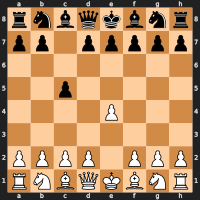

In [14]:
# FEN de ejemplo. Los dos primeros anteriores

#fen = "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1"
fen = "rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq"
# El tablero en la posición FEN descrita y el movimiento de Nakamura fue mover el caballo "g1f3" y 

#fen = "8/8/8/8/8/8/4P3/8 w - - 0 1"

board = chess.Board(fen)

# Muestra el tablero con letras
print(board)

# Muestra el tablero como SVG
display(SVG(chess.svg.board(board=board,size=200)))

# Guardar como archivo SVG
with open("fen_posicion.svg", "w") as f:
    f.write(chess.svg.board(board=board, size=400))


In [15]:
# Mostrar cuántas jugadas de Nakamura hay registradas en ambos colores
df_jugadas.groupBy("Color").count().show()

+-----+-----+
|Color|count|
+-----+-----+
|white|72781|
|black|73146|
+-----+-----+



## 8. Normalización. Convertir el estado FEN en una representación numérica

En entornos locales podemos convertir cada posición FEN a un tensor 8×8×12 de ceros y unos utilizando `NumPy`: 
- **8x8** = las casillas del tablero (filas y columnas).
- **12** = otra dimensión que indicará la pieza que está en esa casilla (6 tipos de pieza para cada color).

Por ejemplo, si hay un peón blanco en la casilla e2, el tensor tendrá un `1` en la posición `[6][4][0]`, es decir:
- Fila 6 (séptima pues comienza en 0). Las filas se cuentan de arriba hacia abajo en el tablero.
- Columna 4 (que es la quinta, es decir, la columna "e") 
- Dimensión correspondiente a la pieza "peón blanco", "P", que es la 0.

En este ámbito podemos aplicar funciones como `apply` sobre un DataFrame de `pandas`. Por otro lado,  se codifican los movimientos en etiquetas numéricas con `LabelEncoder`, lo que facilita su uso en modelos de clasificación como redes neuronales. Este enfoque funciona bien cuando los datos caben en memoria y el procesamiento se realiza en una sola máquina.

### Limitación en entornos distribuidos (Spark)

Dado que Spark trabaja de forma distribuida, no es posible usar directamente estructuras como `numpy.array` o `LabelEncoder` en DataFrames como lo haríamos en Pandas. Esto se debe a que los datos están repartidos entre múltiples nodos y los objetos de Python no se pueden compartir de forma automática. Por eso, en Spark se requiere:

- Usar funciones UDF (User Defined Functions) registradas para aplicar lógica personalizada como la tensorización.
- Aplicar codificación de etiquetas de forma distribuida, ya sea mediante transformaciones con UDFs o utilizando librerías adaptadas a Spark como `pyspark.ml.feature.StringIndexer`.

Esto permite que el procesamiento escale correctamente en clústeres grandes.


### ¿Qué haremos? Vectorización distribuida de posiciones FEN y codificación de movimientos en Spark


1. **Conversión de FEN a vectores**:  
   Definimos la función `fen_to_vector` que convierte una posición FEN en un tensor 8×8×12, y luego lo aplana (flatten) a un vector unidimensional. Esta función se registra como una **UDF (User Defined Function)** para aplicarse sobre cada fila del DataFrame distribuido.

2. **Aplicación de la UDF**:  
   Creamos una nueva columna `"features"` con el vector generado para cada posición FEN, lo que convierte cada partida en un ejemplo de entrada numérico para el modelo.

3. **Separación por color**:  
   Filtramos las jugadas para generar dos conjuntos de datos: uno donde el jugador juega con blancas (`df_white`) y otro con negras (`df_black`).

4. **Codificación de movimientos (etiquetas)**:  
   Como reemplazo de `LabelEncoder`, utilizamos `StringIndexer` de `pyspark.ml`, que transforma cada movimiento en una etiqueta numérica compatible con modelos de aprendizaje automático.

5. **Guardado de clases**:  
   Finalmente, se guardamos las clases (etiquetas codificadas) como archivos `.npy` para reutilizarlas posteriormente, por ejemplo, al decodificar predicciones del modelo.


In [16]:
# UDF para convertir FEN a vector
piece_to_plane = {
    'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
    'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
}

def fen_to_vector(fen):
    tensor = np.zeros((8, 8, 12), dtype=np.float32)
    fen_board = fen.split(' ')[0]
    rows = fen_board.split('/')
    for i, row in enumerate(rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                col_idx += int(char)
            elif char in piece_to_plane:
                plane = piece_to_plane[char]
                tensor[i, col_idx, plane] = 1
                col_idx += 1
    return tensor.flatten().tolist()

# Registrar UDF
fen_udf = udf(fen_to_vector, ArrayType(FloatType()))

# Aplicar la UDF
df_feat = df_jugadas.withColumn("features", fen_udf(col("FEN")))

# Separar por color
df_white = df_feat.filter(col("Color") == "white")
df_black = df_feat.filter(col("Color") == "black")

# Ajustar los indexadores
indexer_white = StringIndexer(inputCol="Move", outputCol="label")
model_white = indexer_white.fit(df_white)
df_white_indexed = model_white.transform(df_white).select("features", "label")

indexer_black = StringIndexer(inputCol="Move", outputCol="label")
model_black = indexer_black.fit(df_black)
df_black_indexed = model_black.transform(df_black).select("features", "label")

# Guardar las clases (etiquetas)
np.save("encoder_blancas.npy", model_white.labels)
np.save("encoder_negras.npy", model_black.labels)

In [17]:
df_white_indexed.printSchema()
df_white_indexed.show(1)
df_black_indexed.printSchema()
df_black_indexed.show(1)

root
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- label: double (nullable = false)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0, 0.0, 0.0, 0...|  8.0|
+--------------------+-----+
only showing top 1 row

root
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- label: double (nullable = false)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0, 0.0, 0.0, 0...|  6.0|
+--------------------+-----+
only showing top 1 row



## 9. Guardado de las jugadas codificadas

In [18]:
# Guardar en HDFS directamente usando Spark
df_white_indexed.write.mode("overwrite").parquet("hdfs:///user/ajedrez/datos_cnn/blancas/fen_jugadas.parquet")
df_black_indexed.write.mode("overwrite").parquet("hdfs:///user/ajedrez/datos_cnn/negras/fen_jugadas.parquet")

In [19]:
 !hdfs dfs -ls /user/ajedrez/datos_cnn/blancas
 !hdfs dfs -ls /user/ajedrez/datos_cnn/negras

Found 1 items
drwxr-xr-x   - root supergroup          0 2025-07-13 11:16 /user/ajedrez/datos_cnn/blancas/fen_jugadas.parquet
Found 1 items
drwxr-xr-x   - root supergroup          0 2025-07-13 11:16 /user/ajedrez/datos_cnn/negras/fen_jugadas.parquet
